
# MDC2018 $e^-$ binned likelihood spectrum fit
In this notebook we will plot the reconstructed momentum spectrum of $e^-$ candidates and we will perform a binned likelihood to get the number of CE and DIOs. A calculation of the corresponding $R_{\mu e}$ is done at the end.

In [14]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import pyhf
import pyhf.readxml
import os
import scipy.stats
import json
import tensorflow as tf
import math

In [15]:
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=False))

In [16]:
def default_flatname(branchname, fieldname, index):
    out = branchname.replace(".", "_")
    if not isinstance(branchname, str):
        out = branchname.decode("utf-8")
    if fieldname is not None:
        fieldname.replace(".", "_")
        out += "_" + fieldname
    if index != ():
        out += "[" + "][".join(str(x) for x in index) + "]"
    return out

In [17]:
cuts = [
    "de_status > 0",
    "de_t0 > 700",
    "de_t0 < 1695",
    "deent_td > 0.577350",
    "deent_td < 1.000",
    "deent_d0 < 105",
    "-deent_d0 < 80",
    "(deent_d0 + 2./deent_om) > 450",
    "(deent_d0 + 2./deent_om) < 680",
    "dequal_TrkQual > 0.8",
    "dequal_TrkPID > 0.95",
    "ue_status <= 0",
    "deent_mom > 95",
    "(bestcrv < 0 | ((-de_t0 + crvinfo__timeWindowStart_best) > 50 | (de_t0-crvinfo__timeWindowStart_best) > 150.0))",
]

cut = " & ".join(cuts)

In [18]:
run_files = ["root_files/trkana-ensemble-run1i-MC.root", 
             "root_files/trkana-ensemble-run2i-MC.root", 
             "root_files/trkana-ensemble-run3i-MC.root", 
             "root_files/trkana-ensemble-run4i-MC.root",
             "root_files/trkana-ensemble-run5i-MC.root",
             "root_files/trkana-ensemble-run6i-MC.root",
             "root_files/trkana-ensemble-run7i-MC.root"]

In [19]:
df_datas = []

true_ces = []
true_dios_reco = []
true_dios = []

for f in run_files:
    file = uproot.open(f)
    trkananeg = file["TrkAnaNeg"]["trkana"]

    df_data = trkananeg.pandas.df(flatname=default_flatname, flatten=False)
    df_data["is_triggered"] = (df_data["trigbits"].values & 0x208) > 0
    df_data["crvinfo__timeWindowStart_best"] = [twstart[index] 
                                           if index>=0 else 0
                                           for index, twstart in zip(df_data["bestcrv"], df_data["crvinfo__timeWindowStart"])]
    df_data["demcgen_mom"] = np.sqrt(df_data["demcgen_momx"]**2+df_data["demcgen_momy"]**2+df_data["demcgen_momz"]**2)

    true_ces.append(len(df_data.query("demcgen_gen==43  & demcgen_mom >= 95")))
    true_dios.append(len(df_data.query("demcgen_gen == 7 & demcgen_mom >= 95")))
    true_dios_reco.append(len(df_data.query("demcgen_gen == 7 & demcgen_mom >= 95 & deent_mom >= 95")))
    
    df_datas.append(df_data.query(cut))
    
    
true_ces_cuts_reco = []
true_dios_cuts_reco = []
for df in df_datas:
    true_dios_cuts_reco.append(len(df.query("demcgen_gen == 7")))
    true_ces_cuts_reco.append(len(df.query("demcgen_gen == 43")))

In [20]:
bounds = [[0.5, 1.5, 0.1], [0.0, 3.0, 0.1], [0.0, 0.05, 0.001]]
labels = ['DIO', 'CE']

In [21]:
def poisson_err(x):
    # From http://www.pp.rhul.ac.uk/~cowan/atlas/ErrorBars.pdf
    upper = 0.5*scipy.stats.chi2.ppf(1-0.158655, 2*(x+1))
    lower = 0.5*scipy.stats.chi2.ppf(0.158655, 2*x)
    return x-lower, upper-x

def ratio_err(num, den, num_err, den_err):
    n, d, n_e, d_e = num, den, num_err, den_err
    return np.abs(n/d) * np.sqrt((n_e/n)**2+(d_e/d)**2)


def get_mc_counts(pars):
    deltas, factors = pdf._modifications(pars)
    allsum = pyhf.tensorlib.concatenate(
        deltas + [pyhf.tensorlib.astensor(pdf.nominal_rates)]
    )
    nom_plus_delta = pyhf.tensorlib.sum(allsum, axis=0)
    nom_plus_delta = pyhf.tensorlib.reshape(
        nom_plus_delta, (1,) + pyhf.tensorlib.shape(nom_plus_delta)
    )
    allfac = pyhf.tensorlib.concatenate(factors + [nom_plus_delta])
    return pyhf.tensorlib.product(allfac, axis=0)


ces = []
dios = []

ces_error = []
dios_error = []

def plot(ax=None, order=[3, 2, 1, 0], errors=[], **par_settings):
    pars = pyhf.tensorlib.astensor(pdf.config.suggested_init())
    for k, v in par_settings.items():
        pars[par_name_dict[k]] = v

    mc_counts = get_mc_counts(pars)
    bottom = None

    for i, sample_index in enumerate(order):
        data = mc_counts[sample_index][0]
        x = np.arange(95,115,0.25)
        err = sum(data)*errors[i+1]
        if i == 1:
            ces.append(sum(data))
            ces_error.append(err)
        if i == 0:
            dios.append(sum(data))
            dios_error.append(err)
        ax.bar(x, data, 0.25, bottom=bottom, alpha=1.0, label=labels[i]+(r": $%.2f\pm%.2f$ events" % (sum(data), err)))
        bottom = data if i == 0 else bottom + data
    
    data_hist = np.array(workspace.data(pdf, with_aux=False))
    ax.errorbar(x, data_hist, yerr=poisson_err(data_hist), fmt='o', color='k', zorder=99)
    

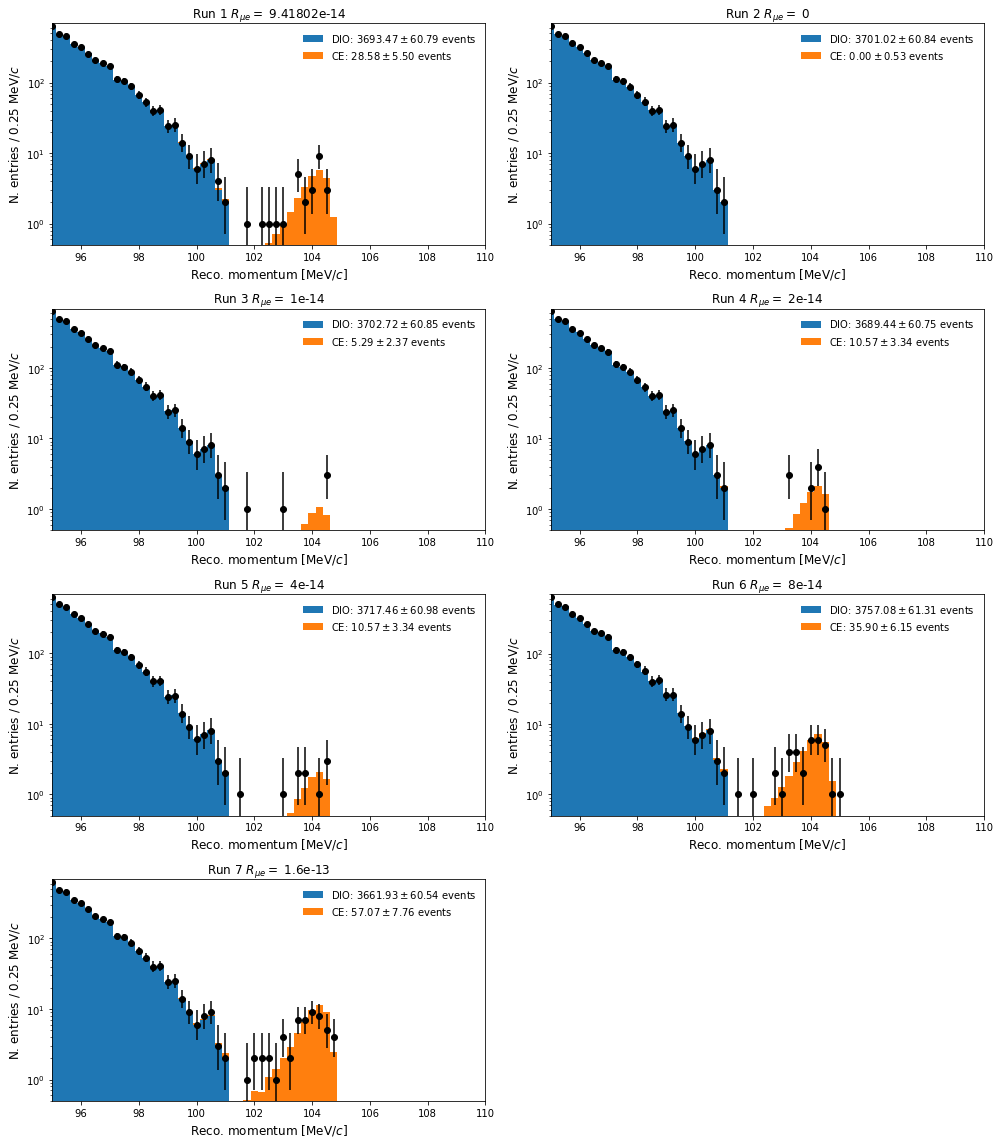

In [22]:
fig, ax = plt.subplots(4,2, figsize=(14, 16))

r_mues = [9.418019e-14,
          0,
          1e-14,
          2e-14,
          4e-14,
          8e-14,
          1.6e-13]

i=0
for row in range(4):
    for column in range(2):
        if i < 7:
            with open("meas.json") as spec_file:
                spec = json.load(spec_file)
            spec['observations'][0]['data'] = np.histogram(df_datas[i]['deent_mom'], bins=80, range=(95,115))[0].tolist()
            workspace = pyhf.Workspace(spec)
            pdf = workspace.model(measurement_name='meas')
            
            par_name_dict = {k: v["slice"].start for k, v in pdf.config.par_map.items()}
            all_par_settings = {
                n[0]: tuple(m)
                for n, m in zip(
                    sorted(reversed(list(par_name_dict.items())), key=lambda x: x[1]),
                    bounds,
                )
            }
            default_par_settings = {n[0]: sum(tuple(m)) / 2.0 for n, m in all_par_settings.items()}
            
            data = workspace.data(pdf)
            workspace.get_measurement(measurement_name='meas')
            best_fit = pyhf.infer.mle.fit(data, pdf, return_uncertainties=True)
            plot(ax=ax[row][column], order=[0,1], errors=best_fit[:, 1]/best_fit[:, 0], **{k: best_fit[:, 0][v] for k,v in par_name_dict.items()});
            ax[row][column].set_title("Run %i $R_{\mu e} =$ %g" % (i+1, r_mues[i]))
            ax[row][column].set_ylim(bottom=0.5)
            ax[row][column].set_xlim(95,110)
            ax[row][column].set_yscale('log')    
            ax[row][column].set_xlabel(r"Reco. momentum [MeV/$c$]", fontsize=12)
            ax[row][column].set_ylabel(r"N. entries / 0.25 MeV/$c$", fontsize=12)
            ax[row][column].legend(frameon=False)
            i+=1

ax[-1, -1].axis('off')
fig.tight_layout()

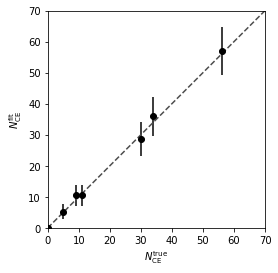

In [23]:
plt.errorbar(true_ces_cuts_reco, ces, yerr=ces_error, fmt='ko')
plt.xlim(0,70)
plt.ylim(0,70)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.axes().set_aspect('equal', 'box')
plt.xlabel(r"$N_{\mathrm{CE}}^{\mathrm{true}}$")
_ = plt.ylabel(r"$N_{\mathrm{CE}}^{\mathrm{fit}}$")

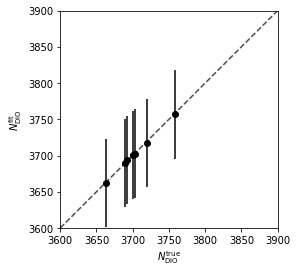

In [24]:
plt.errorbar(true_dios_cuts_reco, dios, yerr=dios_error, fmt='ko')
plt.xlim(3600,3900)
plt.ylim(3600,3900)
plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".3")
plt.axes().set_aspect('equal', 'box')
plt.xlabel(r"$N_{\mathrm{DIO}}^{\mathrm{true}}$")
_ = plt.ylabel(r"$N_{\mathrm{DIO}}^{\mathrm{fit}}$")

## $R_{\mu e}$ calculation

It is possible to calculate the $R_{\mu e}$ corresponding to the number of fitted CEs and DIOS with the following formula:
\begin{equation}
R_{\mu e} = \frac{f_\mathrm{DIO}f_\mathrm{DIO>95~MeV}}{f_\mathrm{cap}}\frac{N_{\mathrm{CE}}}{N_{\mathrm{DIO}}}\frac{p_\mathrm{reco>95~MeV}}{p_\mathrm{true>95~MeV}},
\end{equation}

where $f_\mathrm{cap}=0.609$, $f_\mathrm{DIO}=0.391$, $f_\mathrm{DIO>96.5~MeV}$ is the fraction of DIOs with an energy larger than 96.5 MeV ($1.29\times10^{-11}$), taken from the tabulated Czarnecki-Szafron values, and $\epsilon_{\mathrm{reco}}(E)$ is the cuts efficiency as a function of the reconstructed momentum $p$.

The factor $\frac{p_\mathrm{reco>96.5~MeV}}{p_\mathrm{true>96.5~MeV}}$ takes into account the number of DIOs that gets "smeared out" from our window.

In [25]:
x,y = np.array([]), np.array([])

with open('czarnecki_szafron_Al_2016.tbl', 'r') as f:
    for l in f:
        row = l.split()
        x = np.append(x,float(row[0]))
        y = np.append(y,float(row[1]))

f_dio_start = np.trapz(y[x>=95],x=x[x>=95])

f_cap = 0.609
f_dio = 0.391


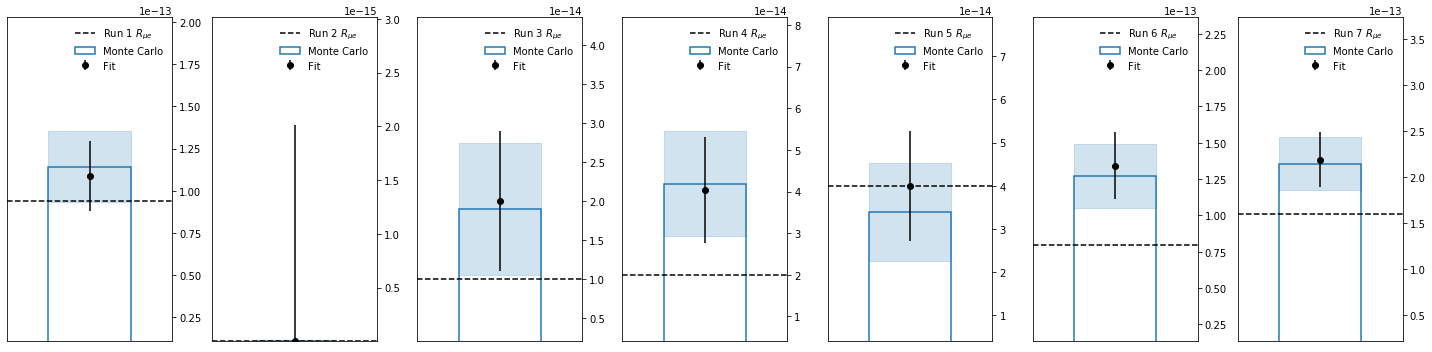

In [26]:
def r_mue(ce_fit, dio_fit, ce_fit_err, dio_fit_err, true_dio, true_dio_reco):
    R_mue = ce_fit/(f_cap/f_dio*dio_fit/f_dio_start)*true_dio_reco/true_dio
    R_mue_err = ratio_err(ce_fit, dio_fit, ce_fit_err, dio_fit_err) * (1/(f_cap/f_dio*1/f_dio_start)*true_dio_reco/true_dio)
    
    return R_mue, R_mue_err


fig, axs = plt.subplots(1,7, figsize=(20,5))
 
for i, ce in enumerate(ces):
    ax = axs[i]
    R_mue_true, R_mue_true_err = r_mue(true_ces_cuts_reco[i], true_dios_cuts_reco[i], np.sqrt(np.asarray(true_ces_cuts_reco[i])), np.sqrt(np.asarray(true_dios_cuts_reco[i])), true_dios[i], true_dios_reco[i])
    R_mue, R_mue_err = r_mue(ce, dios[i], ces_error[i], dios_error[i], true_dios[i], true_dios_reco[i])

    ax.bar(1, height=R_mue_true, lw=1.5, fill=False, label="Monte Carlo", width=1, edgecolor='tab:blue')
    ax.fill_between([0.5, 1.5], R_mue_true-R_mue_true_err, R_mue_true+R_mue_true_err, color='tab:blue', alpha=0.2)
    ax.errorbar(1, R_mue, yerr=[R_mue_err], fmt='ko', label="Fit")
    ax.hlines(r_mues[i], 0, 2, ls='dashed', label=r"Run %i $R_{\mu e}$" % (i+1))
    ax.set_ylim(R_mue*0.1, max(R_mue+R_mue_err, R_mue_true+R_mue_true_err)*1.5)
    ax.set_xlim(0, 2)
    ax.get_xaxis().set_visible(False)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    ax.legend(frameon=False)
    
fig.tight_layout()